###

Must Run as admin

#https://uwspace.uwaterloo.ca/bitstream/handle/10012/11751/Getting%20Started%20with%20Topic%20Modeling%20and%20MALLET%20_%20Programming%20Historian.pdf?sequence=1&isAllowed=y 

In [6]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
#%matplotlib inline

# Enable logging for gensim - optional
#import logging
#logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

#import warnings
#warnings.filterwarnings("ignore",category=DeprecationWarning)

In [7]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [8]:
# Import Dataset
df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')
print(df.target_names.unique())
df.head()

['rec.autos' 'comp.sys.mac.hardware' 'rec.motorcycles' 'misc.forsale'
 'comp.os.ms-windows.misc' 'alt.atheism' 'comp.graphics'
 'rec.sport.baseball' 'rec.sport.hockey' 'sci.electronics' 'sci.space'
 'talk.politics.misc' 'sci.med' 'talk.politics.mideast'
 'soc.religion.christian' 'comp.windows.x' 'comp.sys.ibm.pc.hardware'
 'talk.politics.guns' 'talk.religion.misc' 'sci.crypt']


,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
10,From: irwin@cmptrc.lonestar.org (Irwin Arnstei...,8,rec.motorcycles
100,From: tchen@magnus.acs.ohio-state.edu (Tsung-K...,6,misc.forsale
1000,From: dabl2@nlm.nih.gov (Don A.B. Lindbergh)\n...,2,comp.os.ms-windows.misc


In [9]:
df=df[:1000]

In [10]:
# Convert to list
data = df.content.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

<>:5: DeprecationWarning: invalid escape sequence \S
<>:8: DeprecationWarning: invalid escape sequence \s
<>:5: DeprecationWarning: invalid escape sequence \S
<>:8: DeprecationWarning: invalid escape sequence \s
<>:5: DeprecationWarning: invalid escape sequence \S
<>:8: DeprecationWarning: invalid escape sequence \s
<ipython-input-10-10af9153bd18>:5: DeprecationWarning: invalid escape sequence \S
  data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]
<ipython-input-10-10af9153bd18>:8: DeprecationWarning: invalid escape sequence \s
  data = [re.sub('\s+', ' ', sent) for sent in data]


['From: (wheres my thing) Subject: WHAT car is this!? Nntp-Posting-Host: '
 'rac3.wam.umd.edu Organization: University of Maryland, College Park Lines: '
 '15 I was wondering if anyone out there could enlighten me on this car I saw '
 'the other day. It was a 2-door sports car, looked to be from the late 60s/ '
 'early 70s. It was called a Bricklin. The doors were really small. In '
 'addition, the front bumper was separate from the rest of the body. This is '
 'all I know. If anyone can tellme a model name, engine specs, years of '
 'production, where this car is made, history, or whatever info you have on '
 'this funky looking car, please e-mail. Thanks, - IL ---- brought to you by '
 'your neighborhood Lerxst ---- ']


In [11]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes accentuation

data_words = list(sent_to_words(data))

print(data_words[:1])

[['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp', 'posting', 'host', 'rac', 'wam', 'umd', 'edu', 'organization', 'university', 'of', 'maryland', 'college', 'park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front', 'bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']]


In [12]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp_posting_host', 'rac', 'wam_umd_edu', 'organization', 'university', 'of', 'maryland_college_park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front', 'bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']


In [13]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [14]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_md')

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['where', 's', 'thing', 'car', 'nntp_posting', 'host', 'rac', 'organization', 'university', 'maryland_college', 'park', 'line', 'wonder', 'anyone', 'could', 'enlighten', 'car', 'see', 'day', 'door', 'sport', 'car', 'look', 'late', 'early', 'call', 'bricklin', 'door', 'really', 'small', 'addition', 'front', 'bumper', 'separate', 'rest', 'body', 'know', 'anyone', 'tellme', 'model', 'name', 'engine', 'spec', 'year', 'production', 'car', 'make', 'history', 'info', 'funky', 'look', 'car', 'mail', 'thank', 'bring', 'neighborhood', 'lerxst']]


In [15]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized) #Gensim creates a unique id for each word in the document. 
#The produced corpus shown below is a mapping of (word_id, word_frequency).

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 2), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 5), (8, 1), (9, 1), (10, 2), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 2), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1)]]


In [16]:
id2word[0]

'addition'

In [17]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('addition', 1),
  ('anyone', 2),
  ('body', 1),
  ('bricklin', 1),
  ('bring', 1),
  ('bumper', 1),
  ('call', 1),
  ('car', 5),
  ('could', 1),
  ('day', 1),
  ('door', 2),
  ('early', 1),
  ('engine', 1),
  ('enlighten', 1),
  ('front', 1),
  ('funky', 1),
  ('history', 1),
  ('host', 1),
  ('info', 1),
  ('know', 1),
  ('late', 1),
  ('lerxst', 1),
  ('line', 1),
  ('look', 2),
  ('mail', 1),
  ('make', 1),
  ('maryland_college', 1),
  ('model', 1),
  ('name', 1),
  ('neighborhood', 1),
  ('nntp_posting', 1),
  ('organization', 1),
  ('park', 1),
  ('production', 1),
  ('rac', 1),
  ('really', 1),
  ('rest', 1),
  ('s', 1),
  ('see', 1),
  ('separate', 1),
  ('small', 1),
  ('spec', 1),
  ('sport', 1),
  ('tellme', 1),
  ('thank', 1),
  ('thing', 1),
  ('university', 1),
  ('where', 1),
  ('wonder', 1),
  ('year', 1)]]

In [18]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 2), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 5), (8, 1), (9, 1), (10, 2), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 2), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1)]]


In [19]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)

C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)

C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)

C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)

C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)

C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)

C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)

C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)

C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)

C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)

C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)

C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)

C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)

C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)

C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)

C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)

C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)

C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)

C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)

C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)

C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)

C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)

C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)

C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)

C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)

C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)

C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)

C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)

C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)

C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)

C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)

C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)

C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)

C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)

C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)

C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)

C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)

C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)

C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)

C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)

In [20]:
# Print the Keyword in the 10 topics

#The above LDA model is built with 20 different topics
#where each topic is a combination of keywords and each
#keyword contributes a certain weightage to the topic.

#You can see the keywords for each topic and the weightage(importance) 
#of each keyword using lda_model.print_topics() as shown next.


pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.018*"window" + 0.016*"port" + 0.011*"wide" + 0.010*"medical" + '
  '0.010*"idle" + 0.010*"com" + 0.009*"armenia" + 0.009*"problem" + '
  '0.008*"mouse" + 0.008*"keyboard"'),
 (1,
  '0.026*"c" + 0.011*"cx" + 0.010*"cub" + 0.009*"gc" + 0.009*"mt" + '
  '0.008*"alan" + 0.007*"tor" + 0.007*"x_s" + 0.007*"ck" + 0.006*"det"'),
 (2,
  '0.012*"sc" + 0.006*"annual" + 0.005*"green" + 0.005*"pm" + '
  '0.005*"citizenship" + 0.005*"comic_strip" + 0.005*"comic" + '
  '0.004*"ghost_rider" + 0.004*"armegedon" + 0.004*"spiderman"'),
 (3,
  '0.041*"god" + 0.017*"christian" + 0.016*"believe" + 0.013*"say" + '
  '0.011*"atheist" + 0.011*"religion" + 0.010*"church" + 0.009*"exist" + '
  '0.008*"bible" + 0.008*"evidence"'),
 (4,
  '0.035*"line" + 0.029*"organization" + 0.023*"host" + 0.021*"university" + '
  '0.016*"file" + 0.015*"thank" + 0.014*"program" + 0.012*"entry" + '
  '0.011*"use" + 0.011*"nntp_posting"'),
 (5,
  '0.026*"copy" + 0.014*"disk" + 0.013*"drive" + 0.013*"cost" + 0.012*"work" 

How to interpret this?

Topic 0 is a represented as _0.016“car” + 0.014“power” + 0.010“light” + 0.009“drive” + 0.007“mount” + 0.007“controller” + 0.007“cool” + 0.007“engine” + 0.007“back” + ‘0.006“turn”.

It means the top 10 keywords that contribute to this topic are: ‘car’, ‘power’, ‘light’.. and so on and the weight of ‘car’ on topic 0 is 0.016.

The weights reflect how important a keyword is to that topic.

Looking at these keywords, can you guess what this topic could be? You may summarise it either are ‘cars’ or ‘automobiles’.

Likewise, can you go through the remaining topic keywords and judge what the topic is?

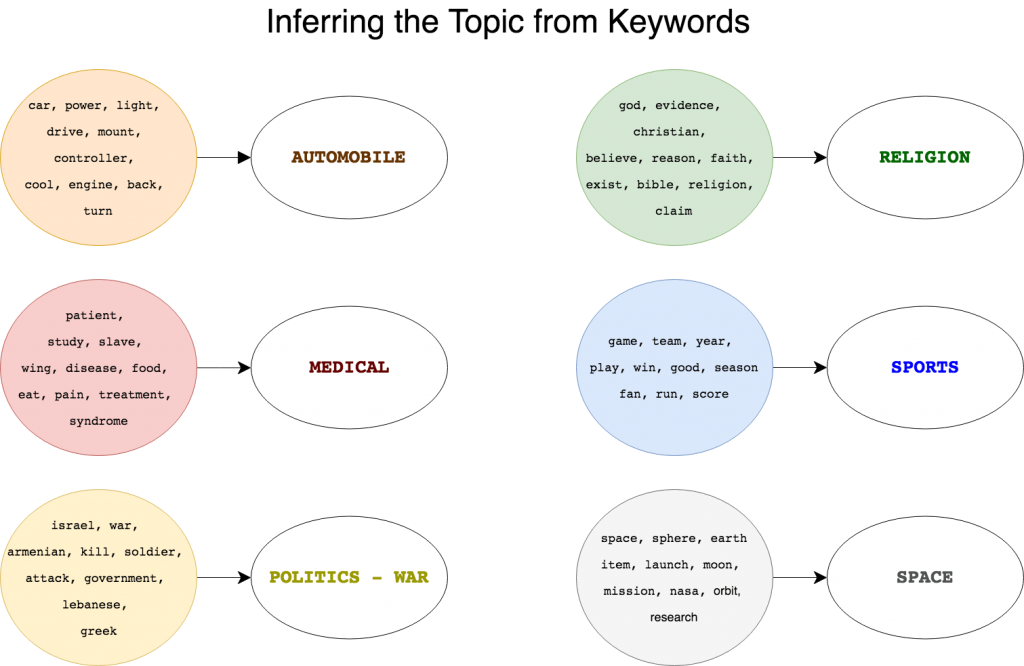

In [21]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)

C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)

C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)

C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)

C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)

C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)

C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)

C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)

C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)

C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)

C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)

C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)

C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)

C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)

C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)

C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)

C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)

C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)

C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)

C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)

C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)

C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)

C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)

C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)

C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)

C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)

C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)

C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)

C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)

C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)

C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)

C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)

C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)

C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)

C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)

C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)

C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)

C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)

C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)

C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Aytu\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)


Perplexity:  -8.4324816649692

Coherence Score:  0.5001535205809071


In [34]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

C:\Users\Aytu\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
14    -0.371405  0.062990       1        1  41.438278
4     -0.237000 -0.173622       2        1   8.046356
3     -0.151038  0.296231       3        1   6.284323
8     -0.011613  0.142398       4        1   4.576828
15    -0.059907 -0.082498       5        1   4.337003
9     -0.073522 -0.066445       6        1   4.189767
11    -0.018163 -0.062268       7        1   3.190184
5     -0.005111 -0.078796       8        1   3.184956
13     0.093166  0.031638       9        1   2.885970
10    -0.012452 -0.124838      10        1   2.882965
6      0.028011 -0.059057      11        1   2.590287
1      0.114539  0.018757      12        1   2.382449
18     0.069001  0.013765      13        1   2.348466
19     0.072392  0.057915      14        1   2.166285
12     0.082106  0.020410      15        1   2.004278
0      0.038387 -0.070523      16        1   1.956883
2      0.126991  0.018808      17        1   1.571312
7      0.106857  0.022297      18        1   1.450249
16     0.095982  0.017894      19        1   1.414078
17     0.112779  0.014945      20        1   1.099092, topic_info=      Category         Freq           Term        Total  loglift  logprob
22     Default  1089.000000           line  1089.000000  30.0000  30.0000
83     Default  1257.000000            not  1257.000000  29.0000  29.0000
460    Default   328.000000            god   328.000000  28.0000  28.0000
31     Default   929.000000   organization   929.000000  27.0000  27.0000
299    Default   546.000000            say   546.000000  26.0000  26.0000
17     Default   391.000000           host   391.000000  25.0000  25.0000
46     Default   431.000000     university   431.000000  24.0000  24.0000
65     Default   771.000000             do   771.000000  23.0000  23.0000
322    Default   861.000000          write   861.000000  22.0000  22.0000
221    Default   433.000000             go   433.000000  21.0000  21.0000
746    Default   166.000000            key   166.000000  20.0000  20.0000
413    Default   479.000000         people   479.000000  19.0000  19.0000
119    Default   610.000000            get   610.000000  18.0000  18.0000
941    Default   233.000000        believe   233.000000  17.0000  17.0000
421    Default   218.000000          state   218.000000  16.0000  16.0000
54     Default   634.000000        article   634.000000  15.0000  15.0000
675    Default   219.000000          right   219.000000  14.0000  14.0000
241    Default   617.000000             be   617.000000  13.0000  13.0000
427    Default   293.000000           work   293.000000  12.0000  12.0000
316    Default   366.000000            use   366.000000  11.0000  11.0000
10193  Default   129.000000          ripem   129.000000  10.0000  10.0000
671    Default   263.000000        problem   263.000000   9.0000   9.0000
153    Default   737.000000          would   737.000000   8.0000   8.0000
2074   Default    90.000000              _    90.000000   7.0000   7.0000
140    Default   278.000000            run   278.000000   6.0000   6.0000
3783   Default   111.000000           scsi   111.000000   5.0000   5.0000
729    Default   168.000000           file   168.000000   4.0000   4.0000
201    Default   266.000000         system   266.000000   3.0000   3.0000
473    Default   431.000000            may   431.000000   2.0000   2.0000
209    Default   144.000000         window   144.000000   1.0000   1.0000
...        ...          ...            ...          ...      ...      ...
2425   Topic20    14.835904             bj    15.604529   4.4602  -4.5358
16469  Topic20    14.122930  beast_profile    14.891555   4.4577  -4.5850
2326   Topic20    12.694659  public_access    13.463284   4.4519  -4.6916
14286  Topic20    12.284733    pentecostal    13.053358   4.4500  -4.7245
1585   Topic20    11.290563         tongue    12.059188   4.4448  -4.8089
7633   Topic20    10.807179    

So how to infer pyLDAvis’s output?

Each bubble on the left-hand side plot represents a topic. The larger the bubble, the more prevalent is that topic.

A good topic model will have fairly big, non-overlapping bubbles scattered throughout the chart instead of being clustered in one quadrant.

A model with too many topics, will typically have many overlaps, small sized bubbles clustered in one region of the chart.

Alright, if you move the cursor over one of the bubbles, the words and bars on the right-hand side will update. These words are the salient keywords that form the selected topic.

We have successfully built a good looking topic model.

Given our prior knowledge of the number of natural topics in the document, finding the best model was fairly straightforward.

Upnext, we will improve upon this model by using Mallet’s version of LDA algorithm and then we will focus on how to arrive at the optimal number of topics given any large corpus of text.

In [23]:
#from pathlib import Path
#home = str(Path("C:", "mallet"))
#binary = str(Path("C:", "mallet", "bin", "mallet"))
#home

In [24]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip"
import os

os.environ["MALLET_HOME"] = "C:\\mallet"
mallet_path = "C:\\mallet\\bin\\mallet.bat" # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

So far you have seen Gensim’s inbuilt version of the LDA algorithm. Mallet’s version, however, often gives a better quality of topics.

Gensim provides a wrapper to implement Mallet’s LDA from within Gensim itself. You only need to download the zipfile, unzip it and provide the path to mallet in the unzipped directory to gensim.models.wrappers.LdaMallet. See how I have done this below.

In [25]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(11,
  [('team', 0.024932873034138856),
   ('game', 0.023590333716915997),
   ('run', 0.0189873417721519),
   ('win', 0.018411967779056387),
   ('play', 0.017069428461833524),
   ('player', 0.014384349827387802),
   ('year', 0.01169927119294208),
   ('good', 0.01016494054468738),
   ('lose', 0.009397775220560031),
   ('fan', 0.009014192558496356)]),
 (2,
  [('_', 0.04682597151822351),
   ('sc', 0.016413227130098962),
   ('cx', 0.014240888245232923),
   ('hz', 0.013999517258025585),
   ('gc', 0.012309920347574221),
   ('ss', 0.009896210475500844),
   ('mv', 0.009896210475500844),
   ('x_s', 0.009654839488293506),
   ('ck', 0.008689355539464157),
   ('md', 0.008447984552256819)]),
 (10,
  [('image', 0.019483461712732214),
   ('copy', 0.0158586316266425),
   ('book', 0.01517897598550068),
   ('computer', 0.012913457181694609),
   ('include', 0.012233801540552787),
   ('reference', 0.012233801540552787),
   ('source', 0.01200724966017218),
   ('lab', 0.008382419574082464),
   ('datum', 0.

17. How to find the optimal number of topics for LDA?
My approach to finding the optimal number of topics is to build many LDA models with different values of number of topics (k) and pick the one that gives the highest coherence value.

Choosing a ‘k’ that marks the end of a rapid growth of topic coherence usually offers meaningful and interpretable topics. Picking an even higher value can sometimes provide more granular sub-topics.

If you see the same keywords being repeated in multiple topics, it’s probably a sign that the ‘k’ is too large.

The compute_coherence_values() (see below) trains multiple LDA models and provides the models and their corresponding coherence scores.

In [26]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [27]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

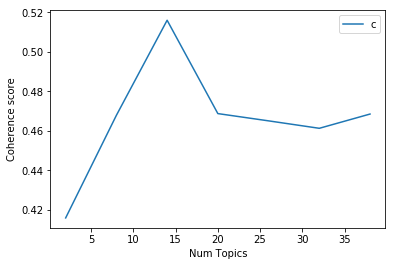

In [28]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [29]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4158
Num Topics = 8  has Coherence Value of 0.4678
Num Topics = 14  has Coherence Value of 0.516
Num Topics = 20  has Coherence Value of 0.4687
Num Topics = 26  has Coherence Value of 0.465
Num Topics = 32  has Coherence Value of 0.4613
Num Topics = 38  has Coherence Value of 0.4685


In [30]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.019*"team" + 0.019*"organization" + 0.017*"play" + 0.016*"line" + '
  '0.016*"game" + 0.014*"university" + 0.012*"write" + 0.012*"player" + '
  '0.010*"guy" + 0.010*"hockey"'),
 (1,
  '0.040*"time" + 0.028*"good" + 0.021*"make" + 0.019*"work" + 0.016*"thing" + '
  '0.016*"back" + 0.015*"point" + 0.014*"problem" + 0.014*"put" + '
  '0.011*"give"'),
 (2,
  '0.080*"organization" + 0.078*"line" + 0.074*"university" + 0.056*"host" + '
  '0.025*"nntp_posting" + 0.020*"nntp_poste" + 0.017*"write" + 0.015*"reply" + '
  '0.012*"interested" + 0.012*"test"'),
 (3,
  '0.015*"sale" + 0.013*"book" + 0.013*"system" + 0.012*"price" + 0.012*"copy" '
  '+ 0.011*"image" + 0.010*"space" + 0.009*"base" + 0.007*"computer" + '
  '0.007*"orbit"'),
 (4,
  '0.026*"run" + 0.022*"win" + 0.019*"article" + 0.013*"lose" + 0.013*"bike" + '
  '0.012*"hit" + 0.011*"year" + 0.011*"game" + 0.011*"line" + 0.010*"team"'),
 (5,
  '0.034*"people" + 0.021*"government" + 0.019*"state" + 0.012*"american" + '
  '0.010*

18. Finding the dominant topic in each sentence
One of the practical application of topic modeling is to determine what topic a given document is about.

To find that, we find the topic number that has the highest percentage contribution in that document.

The format_topics_sentences() function below nicely aggregates this information in a presentable table.

In [43]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,14.0,0.1377,"car, cost, buy, sell, friend, experience, arti...",From: (wheres my thing) Subject: WHAT car is t...
1,1,10.0,0.2530,"drive, card, driver, work, scsi, system, mac, ...",From: (Guy Kuo) Subject: SI Clock Poll - Final...
2,2,14.0,0.2526,"car, cost, buy, sell, friend, experience, arti...",From: (Irwin Arnstein) Subject: Re: Recommenda...
3,3,13.0,0.3971,"window, line, internet, organization, write, r...",From: (Tsung-Kun Chen) Subject: ** Software fo...
4,4,10.0,0.2117,"drive, card, driver, work, scsi, system, mac, ...",From: (Don A.B. Lindbergh) Subject: Diamond SS...
5,5,14.0,0.1515,"car, cost, buy, sell, friend, experience, arti...",From: (Robert Loper) Subject: Re: SHO and SC N...
6,6,11.0,0.1304,"line, organization, host, nntp_poste, nntp_pos...",From: (Kim Richard Man) Subject: SyQuest 44M c...
7,7,13.0,0.2574,"window, line, internet, organization, write, r...",From: (Kirtley Wilson) Subject: Mirosoft Offic...
8,8,8.0,0.1881,"write, article, organization, make, line, post...",Subject: Re: Dont more innocents die without t...
9,9,6.0,0.3445,"science, god, question, people, exist, thing, ...",From: (Jon Livesey) Subject: Re: Genocide is C...


19. Find the most representative document for each topic
Sometimes just the topic keywords may not be enough to make sense of what a topic is about. So, to help with understanding the topic, you can find the documents a given topic has contributed to the most and infer the topic by reading that document. Whew!!

In [44]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head()], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.6969,"team, organization, play, line, game, universi...",From: (Droopy) Subject: AHL Calder Cup Playoff...
1,0.0,0.5068,"team, organization, play, line, game, universi...",From: (Andrew Scott) Subject: USENET Hockey Dr...
2,0.0,0.5002,"team, organization, play, line, game, universi...",From: (Gerald Olchowy) Subject: Re: Too Many E...
3,0.0,0.4788,"team, organization, play, line, game, universi...",From: (George Pavlic) Subject: Re: Pens playof...
4,0.0,0.4570,"team, organization, play, line, game, universi...",Organization: Penn State University From: Robb...
5,1.0,0.5169,"time, good, make, work, thing, back, point, pr...",From: (Ronald W. Schmidt) Subject: outlining o...
6,1.0,0.5056,"time, good, make, work, thing, back, point, pr...",From: (David McAloon) Subject: PLANETS STILL: ...
7,1.0,0.3783,"time, good, make, work, thing, back, point, pr...",From: (Craig Keithley) Subject: Re: Why not gi...
8,1.0,0.3495,"time, good, make, work, thing, back, point, pr...",From: (90-29265 Webber AH) Subject: Re: Adcom ...
9,1.0,0.3486,"time, good, make, work, thing, back, point, pr...",From: diablo.UUCP!cboesel (Charles Boesel) Sub...


20. Topic distribution across documents
Finally, we want to understand the volume and distribution of topics in order to judge how widely it was discussed. The below table exposes that information.

In [33]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,14.0,"car, cost, buy, sell, friend, experience, arti...",56.0,0.056
1,10.0,"drive, card, driver, work, scsi, system, mac, ...",44.0,0.044
2,14.0,"car, cost, buy, sell, friend, experience, arti...",79.0,0.079
3,13.0,"window, line, internet, organization, write, r...",49.0,0.049
4,10.0,"drive, card, driver, work, scsi, system, mac, ...",54.0,0.054
5,14.0,"car, cost, buy, sell, friend, experience, arti...",21.0,0.021
6,11.0,"line, organization, host, nntp_poste, nntp_pos...",42.0,0.042
7,13.0,"window, line, internet, organization, write, r...",20.0,0.020
8,8.0,"write, article, organization, make, line, post...",67.0,0.067
9,6.0,"science, god, question, people, exist, thing, ...",37.0,0.037


In [35]:
# https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

We started with understanding what topic modeling can do. We built a basic topic model using Gensim’s LDA and visualize the topics using pyLDAvis. Then we built mallet’s LDA implementation. You saw how to find the optimal number of topics using coherence scores and how you can come to a logical understanding of how to choose the optimal model.

Finally we saw how to aggregate and present the results to generate insights that may be in a more actionable.

Hope you enjoyed reading this. I would appreciate if you leave your thoughts in the comments section below.

In [ ]:
 for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

In [39]:
xx=lda_model.show_topic(0)

In [40]:
topic_keywords1 = ", ".join([word for word, prop in xx])

In [41]:
topic_keywords1

'window, port, wide, medical, idle, com, armenia, problem, mouse, keyboard'